In [684]:
import sys 
sys.path.append('../..')
from cox.utils import Parameters
from cox.store import Store
from cox.readers import CollectionReader
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import itertools
import numpy as np
import torch as ch
from torch import Tensor
import torch.nn as nn
from torch.distributions import Gumbel, Uniform
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
import datetime
from delphi.oracle import oracle

## Default Experiment Parameters

In [890]:
# procedure hyperparameters
args = Parameters({ 
    'epochs': 25,
    'num_workers': 0, 
    'batch_size': 10,
    'bias': True,
    'num_samples': 1000,
    'clamp': True, 
    'radius': 5.0, 
    'var_lr': 1e-2,
    'lr': 1e-1,
    'shuffle': False, 
    'tol': 1e-2,
    'samples': 10000,  # number of samples to generate for ground truth
    'in_features': 3, # number of in-features to multi-log-reg
    'k': 2, # number of classes
    'lower': -1, # lower bound for generating ground truth weights
    'upper': 1,  # upper bound for generating ground truth weights
    'custom_criterion': F.gumbel_softmax,
    'trials': 10,
})

# Generate Synthetic Data

In [623]:
# generate ground-truth from uniform distribution
U = Uniform(args.lower, args.upper)
ground_truth = nn.Linear(in_features=args.IN_FEATURES, out_features=args.K, bias=args.bias)
ground_truth.weight = nn.Parameter(U.sample(ch.Size([args.K, args.IN_FEATURES])))
if ground_truth.bias is not None: 
    ground_truth.bias = nn.Parameter(U.sample(ch.Size([args.K,])))
print("ground truth weights: {}".format(ground_truth.weight))
print("ground truth bias: {}".format(ground_truth.bias))
# independent variable 
U_ = Uniform(-5, 5)
X = U_.sample(ch.Size([args.samples, args.IN_FEATURES]))
# determine base model logits 
z = ground_truth(X)
# apply softmax to unnormalized likelihoods
y = ch.argmax(ch.nn.Softmax(dim=1)(z), dim=1)

ground truth weights: Parameter containing:
tensor([[-0.2086],
        [-0.2106]], requires_grad=True)
ground truth bias: Parameter containing:
tensor([ 0.1975, -0.1717], requires_grad=True)


# Algorithm Parameters

In [624]:
# all synthetic data 
ds = TensorDataset(X, y)
# split ds into training and validation data sets
train_length = int(len(ds)*.8)
val_length = len(ds) - train_length
train_ds, val_ds = ch.utils.data.random_split(ds, [train_length, val_length])
# train and validation loaders
train_loader = DataLoader(train_ds, num_workers=args.num_workers, batch_size=args.batch_size)
val_loader = DataLoader(val_ds, num_workers=args.num_workers, batch_size=args.batch_size)
# gradients
gumbel_ce = GumbelCE.apply
ce_loss = nn.CrossEntropyLoss()

# PyTorch CE Loss

In [488]:
# CE LOSS TABLE FOR METRICS
CE_LOSS_TABLE_NAME = 'ce_loss'

STORE_PATH = '/home/pstefanou/MultinomialLogisticRegression'
store = Store(STORE_PATH)

store.add_table(CE_LOSS_TABLE_NAME, { 
    'train_acc': float, ""
    'val_acc': float, 
    'train_loss': float, 
    'val_loss': float,
    'epoch': int,
})

Logging in: /home/pstefanou/MultinomialLogisticRegression/3ae8814e-7019-4115-99ff-f01a61adb1f5


In [489]:
multi_log_reg = nn.Linear(in_features=args.IN_FEATURES, out_features=args.K, bias=args.bias)
# optimizer and scheduler
optimizer = ch.optim.SGD(multi_log_reg.parameters(), lr=1e-1)
scheduler = ch.optim.lr_scheduler.CosineAnnealingLR(optimizer, args.epochs)

for i in range(args.trials):
    for epoch in range(args.epochs): 
        # train loop
        train_loss, train_acc = Tensor([]), Tensor([])
        for batch_X, batch_y in train_loader: 
            optimizer.zero_grad()
            pred = multi_log_reg(batch_X)
            loss = ce_loss(pred,  batch_y)
            loss.backward()
            optimizer.step()
            scheduler.step()
            # keep track of algorithm training loss and accuracy
            acc = (ch.argmax(ch.nn.Softmax(dim=1)(pred), dim=1) == batch_y).sum() / batch_y.size(0)
            train_loss = ch.cat([train_loss, Tensor([loss])]) if train_loss.size() != ch.Size([0]) else Tensor([loss])
            train_acc = ch.cat([train_acc, Tensor([acc])]) if train_acc.size() != ch.Size([0]) else Tensor([acc])
        # validation loop
        val_loss, val_acc = Tensor([]), Tensor([])
        with ch.no_grad(): 
            for batch_X, batch_y in val_loader: 
                pred = multi_log_reg(batch_X)
                loss = ce_loss(pred, batch_y)
                # keep track of algorithm validation loss and accuracy
                acc = (ch.argmax(ch.nn.Softmax(dim=1)(pred), dim=1) == batch_y).sum() / batch_y.size(0)            
                val_loss = ch.cat([val_loss, Tensor([loss])]) if val_loss.size() != ch.Size([0]) else Tensor([loss])
                val_acc = ch.cat([val_acc, Tensor([acc])]) if val_acc.size() != ch.Size([0]) else Tensor([acc])

        store[CE_LOSS_TABLE_NAME].append_row({ 
            'train_acc': float(train_acc.mean()), 
            'val_acc': float(val_acc.mean()), 
            'train_loss': float(train_loss.mean()), 
            'val_loss': float(val_loss.mean()),
            'epoch': int(epoch + 1),
        })
store.close()

# Read Results Experiment

In [490]:
reader = CollectionReader(STORE_PATH)
results = reader.df(CE_LOSS_TABLE_NAME)
reader.close() # close reader
results.head()

100%|██████████| 1/1 [00:00<00:00, 63.71it/s]


,train_acc,val_acc,train_loss,val_loss,epoch,exp_id
0,0.894625,0.9320,0.302855,0.185647,1,3ae8814e-7019-4115-99ff-f01a61adb1f5
1,0.940750,0.9525,0.156548,0.145880,2,3ae8814e-7019-4115-99ff-f01a61adb1f5
2,0.954875,0.9640,0.131026,0.130627,3,3ae8814e-7019-4115-99ff-f01a61adb1f5
3,0.963125,0.9685,0.116563,0.116246,4,3ae8814e-7019-4115-99ff-f01a61adb1f5
4,0.969875,0.9715,0.106702,0.108101,5,3ae8814e-7019-4115-99ff-f01a61adb1f5


# Plot Loss and Accuracy Curves

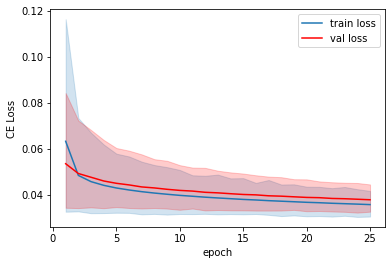

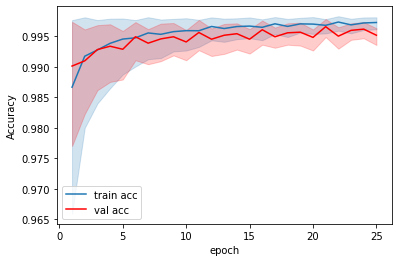

In [491]:
sns.lineplot(data=results, x='epoch', y='train_loss', label='train loss')
ax = sns.lineplot(data=results, x='epoch', y='val_loss', color='red', label='val loss')
ax.set(xlabel='epoch', ylabel='CE Loss')
plt.show()

sns.lineplot(data=results, x='epoch', y='train_acc', label='train acc')
ax = sns.lineplot(data=results, x='epoch', y='val_acc', color='red', label='val acc')
ax.set(xlabel='epoch', ylabel='Accuracy')
plt.show()

# CE Latent Variable Model Loss

In [642]:
gumbel = Gumbel(0, 1)

class GumbelCE(ch.autograd.Function):
    @staticmethod
    def forward(ctx, pred, targ):
        ctx.save_for_backward(pred, targ)
        loss = ch.nn.CrossEntropyLoss()
        calc = loss(pred, targ)
        return calc

    @staticmethod
    def backward(ctx, grad_output):
        pred, targ = ctx.saved_tensors
        # make num_samples copies of pred logits
        stacked = pred[None, ...].repeat(args.num_samples, 1, 1)        
        # add gumbel noise to logits
        noised = stacked + gumbel.sample(stacked.size())
        # remove noisy logits that fall below z_k
        for i in range(noised.size(1)): # iterate over samples within batch
            # get minimum noisy logit for kth class
            z_k_max = ch.max(noised[:, i, int(targ[i])])
            # remove logits that are strictly larger than z_k_min
            for j in range(noised.size(2)):
                if j != targ[i]: 
                    values = noised[:, i, j]
                    noised[:, i, j] = ch.where(values > z_k_max, ch.zeros(1), values) 
        out = noised - stacked
#         print("pred: {}".format(pred.size()))
#         print("out: {}".format(out))
#         out = noised.max(dim = 0)[0]
#         out = noised.sum(dim = 0) / (noised.count_nonzero(dim=0) + 1e-5)
#         print("out: {}".format(out))
        # calculate gradient 
        grad = 1 - ch.exp(-out)
        print("grad: {}".format(grad.size()))
        grad_mean = grad.sum(dim = 0) / (grad.count_nonzero(dim=0) + 1e-5)
        print("grad mean: {}".format(grad_mean))
#         print("grad: {}".format(grad.size()))
#         print("grad: {}".format(grad / pred.size(0)))
        return grad_mean / pred.size(0), None

In [666]:
gumbel = Gumbel(0, 1)

class GumbelCE(ch.autograd.Function):
    @staticmethod
    def forward(ctx, pred, targ):
        ctx.save_for_backward(pred, targ)
        loss = ch.nn.CrossEntropyLoss()
        return loss(pred, targ)

    @staticmethod
    def backward(ctx, grad_output):
        pred, targ = ctx.saved_tensors
        # make num_samples copies of pred logits
        stacked = pred[None, ...].repeat(1000, 1, 1)        
        # add gumbel noise to logits
        rand_noise = gumbel.sample(stacked.size())
        noised = stacked + rand_noise 
        noised_labs = noised.argmax(-1)
        # remove the logits from the trials, where the kth logit is not the largest value
        good_mask = noised_labs.eq(targ)[..., None]
        inner_exp = 1 - ch.exp(-rand_noise)
        avg = (inner_exp * good_mask).sum(0) / (good_mask.sum(0) + 1e-5) / pred.size(0)
        return -avg , None

In [814]:
# CE LOSS TABLE FOR METRICS
LATENT_CE_TABLE_NAME = 'latent_ce_grad'

STORE_PATH = '/home/pstefanou/MultinomialLogisticRegression'
store = Store(STORE_PATH)

store.add_table(LATENT_CE_TABLE_NAME, { 
    'train_acc': float, 
    'val_acc': float, 
    'train_loss': float, 
    'val_loss': float,
    'epoch': int,
})

Logging in: /home/pstefanou/MultinomialLogisticRegression/8f0f5d89-0b21-4fec-b950-fc836c4b2abb


In [815]:
multi_log_reg = nn.Linear(in_features=args.IN_FEATURES, out_features=args.K, bias=args.bias)
# optimizer and scheduler
optimizer = ch.optim.SGD(multi_log_reg.parameters(), lr=1e-1)
scheduler = ch.optim.lr_scheduler.CosineAnnealingLR(optimizer, args.epochs)

for i in range(args.trials):
    for epoch in range(args.epochs): 
        # train loop
        train_loss, train_acc = Tensor([]), Tensor([])
        for batch_X, batch_y in train_loader: 
            optimizer.zero_grad()
            pred = multi_log_reg(batch_X)
            loss = ce_loss(pred, batch_y)
            loss.backward(retain_graph=True) 
#             print("softmax grad: {}".format(multi_log_reg.weight.grad))
            optimizer.zero_grad() 
            loss = GumbelCE.apply(pred,  batch_y)
            loss.backward()
#             print("latent variable grad: {}".format(multi_log_reg.weight.grad))
#             print(("---"))
            optimizer.step()
            scheduler.step()
            # keep track of algorithm training loss and accuracy
            acc = (ch.argmax(ch.nn.Softmax(dim=1)(pred), dim=1) == batch_y).sum() / batch_y.size(0)
            train_loss = ch.cat([train_loss, Tensor([loss])]) if train_loss.size() != ch.Size([0]) else Tensor([loss])
            train_acc = ch.cat([train_acc, Tensor([acc])]) if train_acc.size() != ch.Size([0]) else Tensor([acc])
        # validation loop
        val_loss, val_acc = Tensor([]), Tensor([])
        with ch.no_grad(): 
            for batch_X, batch_y in val_loader: 
                pred = multi_log_reg(batch_X)
                loss = gumbel_ce(pred, batch_y)
                # keep track of algorithm validation loss and accuracy
                acc = (ch.argmax(ch.nn.Softmax(dim=1)(pred), dim=1) == batch_y).sum() / batch_y.size(0)            
                val_loss = ch.cat([val_loss, Tensor([loss])]) if val_loss.size() != ch.Size([0]) else Tensor([loss])
                val_acc = ch.cat([val_acc, Tensor([acc])]) if val_acc.size() != ch.Size([0]) else Tensor([acc])

        store[LATENT_CE_TABLE_NAME].append_row({ 
            'train_acc': float(train_acc.mean()), 
            'val_acc': float(val_acc.mean()), 
            'train_loss': float(train_loss.mean()), 
            'val_loss': float(val_loss.mean()),
            'epoch': int(epoch + 1),
        })
store.close()

KeyboardInterrupt: 

In [ ]:
reader = CollectionReader(STORE_PATH)
results = reader.df(LATENT_CE_TABLE_NAME)
reader.close() # close reader
results

In [ ]:
sns.lineplot(data=results, x='epoch', y='train_loss', label='train loss')
ax = sns.lineplot(data=results, x='epoch', y='val_loss', color='red', label='val loss')
ax.set(xlabel='epoch', ylabel='Gumbel CE Loss')
plt.show()

sns.lineplot(data=results, x='epoch', y='train_acc', label='train acc')
ax = sns.lineplot(data=results, x='epoch', y='val_acc', color='red', label='val acc')
ax.set(xlabel='epoch', ylabel='Accuracy')
plt.show()

# Truncated Multinomial Logistic Regression Experiments

In [889]:
class TruncatedGumbelCE(ch.autograd.Function):
    @staticmethod
    def forward(ctx, pred, targ, phi):
        ctx.save_for_backward(pred, targ)
        ctx.phi = phi
        ce_loss = ch.nn.CrossEntropyLoss()
        return ce_loss(pred, targ)

    @staticmethod
    def backward(ctx, grad_output):
        pred, targ = ctx.saved_tensors
        # make num_samples copies of pred logits
        stacked = pred[None, ...].repeat(args.num_samples, 1, 1)   
        # add gumbel noise to logits
        rand_noise = gumbel.sample(stacked.size())
        noised = stacked + rand_noise 
        # truncate - if one of the noisy logits does not fall within the truncation set, remove it
        print(ctx.phi(noised))
#         filtered = ch.all(ctx.phi(noised).bool(), dim=2).float().unsqueeze(2)
        filtered = ch.all(ctx.phi(noised).bool(), dim=2).float().unsqueeze(2)
        noised_labs = noised.argmax(-1)
        # mask takes care of invalid logits and truncation set
        mask = noised_labs.eq(targ)[..., None] * filtered
        inner_exp = 1 - ch.exp(-rand_noise)
        avg = ((inner_exp * mask).sum(0) / (mask.sum(0) + 1e-5) - (inner_exp * filtered) / (filtered.sum(0) + 1e-5)) 
        return -avg / pred.size(0), None, None

Membership oracles for Multinomial Logistic Regression Logits 

In [916]:
class DNN_Lower(oracle): 
    """
    Lower bound truncation on the DNN logits.
    """
    def __init__(self, lower): 
        self.lower = lower
        
    def __call__(self, x): 
        return (x > self.lower).float()

In [855]:
class Identity(oracle): 
    def __call__(self, x): 
        return ch.ones(x.size())

Truncate Dataset

In [917]:
phi = DNN_Lower(Tensor([-1, -1]))
id_ = Identity()

In [918]:
# generate ground-truth from uniform distribution
U = Uniform(args.lower, args.upper)
ground_truth = nn.Linear(in_features=args.IN_FEATURES, out_features=args.K, bias=args.bias)
ground_truth.weight = nn.Parameter(U.sample(ch.Size([args.K, args.IN_FEATURES])))
if ground_truth.bias is not None: 
    ground_truth.bias = nn.Parameter(U.sample(ch.Size([args.K,])))
print("ground truth weights: {}".format(ground_truth.weight))
print("ground truth bias: {}".format(ground_truth.bias))
# independent variable 
U_ = Uniform(-5, 5)
X = U_.sample(ch.Size([args.samples, args.IN_FEATURES]))
# determine base model logits 
z = ground_truth(X)
# apply softmax to unnormalized likelihoods
y = ch.argmax(ch.nn.Softmax(dim=1)(z), dim=1)

# TRUNCATE
trunc = phi(z)
indices = ch.all(trunc.bool(), dim=1).float().nonzero(as_tuple=False).flatten()
y_trunc = y[indices]
x_trunc = X[indices]
alpha = x_trunc.size(0) / X.size(0)
print("alpha: {}".format(alpha))

# all synthetic data 
ds = TensorDataset(x_trunc, y_trunc)
# split ds into training and validation data sets
train_length = int(len(ds)*.8)
val_length = len(ds) - train_length
train_ds, val_ds = ch.utils.data.random_split(ds, [train_length, val_length])
# train and validation loaders
train_loader = DataLoader(train_ds, num_workers=args.num_workers, batch_size=args.batch_size)
val_loader = DataLoader(val_ds, num_workers=args.num_workers, batch_size=args.batch_size)

ground truth weights: Parameter containing:
tensor([[-0.9858,  0.7326, -0.8205],
        [ 0.7930, -0.1973,  0.5626]], requires_grad=True)
ground truth bias: Parameter containing:
tensor([ 0.7203, -0.8409], requires_grad=True)
alpha: 0.1697


In [882]:
# CE LOSS TABLE FOR METRICS
LATENT_CE_TABLE_NAME = 'truncated_ce_grad'

STORE_PATH = '/home/pstefanou/MultinomialLogisticRegression'
store = Store(STORE_PATH)

store.add_table(LATENT_CE_TABLE_NAME, { 
    'train_acc': float, 
    'val_acc': float, 
    'train_loss': float, 
    'val_loss': float,
    'epoch': int,
})

Logging in: /home/pstefanou/MultinomialLogisticRegression/486dd7af-b99d-4e8d-83be-9c0345b04874


In [885]:
multi_log_reg = nn.Linear(in_features=args.IN_FEATURES, out_features=args.K, bias=args.bias)
# optimizer and scheduler
optimizer = ch.optim.SGD(multi_log_reg.parameters(), lr=1e-1)
scheduler = ch.optim.lr_scheduler.CosineAnnealingLR(optimizer, args.epochs)
trunc_ce_loss = TruncatedGumbelCE.apply

for i in range(args.trials):
    for epoch in range(args.epochs): 
        # train loop
        train_loss, train_acc = Tensor([]), Tensor([])
        for batch_X, batch_y in train_loader: 
            optimizer.zero_grad()
            pred = multi_log_reg(batch_X)
            loss = trunc_ce_loss(pred, batch_y, phi)
            loss.backward() 
            optimizer.step()
            scheduler.step()
            # keep track of algorithm training loss and accuracy
            acc = (ch.argmax(ch.nn.Softmax(dim=1)(pred), dim=1) == batch_y).sum() / batch_y.size(0)
            train_loss = ch.cat([train_loss, Tensor([loss])]) if train_loss.size() != ch.Size([0]) else Tensor([loss])
            train_acc = ch.cat([train_acc, Tensor([acc])]) if train_acc.size() != ch.Size([0]) else Tensor([acc])
        # validation loop
        val_loss, val_acc = Tensor([]), Tensor([])
        with ch.no_grad(): 
            for batch_X, batch_y in val_loader: 
                pred = multi_log_reg(batch_X)
                loss = trunc_ce_loss(pred, batch_y, phi)
                # keep track of algorithm validation loss and accuracy
                acc = (ch.argmax(ch.nn.Softmax(dim=1)(pred), dim=1) == batch_y).sum() / batch_y.size(0)            
                val_loss = ch.cat([val_loss, Tensor([loss])]) if val_loss.size() != ch.Size([0]) else Tensor([loss])
                val_acc = ch.cat([val_acc, Tensor([acc])]) if val_acc.size() != ch.Size([0]) else Tensor([acc])

        store[LATENT_CE_TABLE_NAME].append_row({ 
            'train_acc': float(train_acc.mean()), 
            'val_acc': float(val_acc.mean()), 
            'train_loss': float(train_loss.mean()), 
            'val_loss': float(val_loss.mean()),
            'epoch': int(epoch + 1),
        })
store.close()

tensor([[1., 1.],
        [0., 1.],
        [0., 1.],
        ...,
        [1., 1.],
        [1., 1.],
        [0., 1.]])


IndexError: Dimension out of range (expected to be in range of [-2, 1], but got 2)

# Read Experiment Data from Store

In [860]:
reader = CollectionReader(STORE_PATH)
results = reader.df(LATENT_CE_TABLE_NAME)
reader.close() # close reader
results.head()

100%|██████████| 2/2 [00:00<00:00, 114.07it/s]


,train_acc,val_acc,train_loss,val_loss,epoch,exp_id
0,0.648000,1.0,155.355606,0.0,1,3ec1ef66-d229-4093-bb3b-c4089ce80d42
1,0.992625,1.0,0.416854,0.0,2,3ec1ef66-d229-4093-bb3b-c4089ce80d42
2,0.999750,1.0,0.002636,0.0,3,3ec1ef66-d229-4093-bb3b-c4089ce80d42
3,0.999875,1.0,0.001223,0.0,4,3ec1ef66-d229-4093-bb3b-c4089ce80d42
4,0.998500,1.0,0.025111,0.0,5,3ec1ef66-d229-4093-bb3b-c4089ce80d42


# Loss and Accuracy Curves

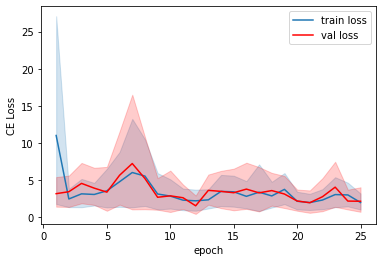

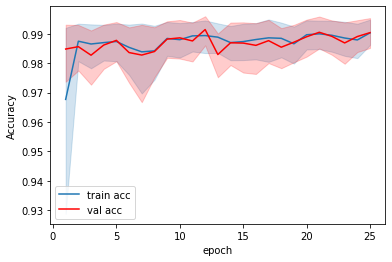

In [861]:
sns.lineplot(data=results, x='epoch', y='train_loss', label='train loss')
ax = sns.lineplot(data=results, x='epoch', y='val_loss', color='red', label='val loss')
ax.set(xlabel='epoch', ylabel='CE Loss')
plt.show()

sns.lineplot(data=results, x='epoch', y='train_acc', label='train acc')
ax = sns.lineplot(data=results, x='epoch', y='val_acc', color='red', label='val acc')
ax.set(xlabel='epoch', ylabel='Accuracy')
plt.show()

In [887]:
batch_X.size()

torch.Size([10, 3])

In [888]:
batch_y.size()

torch.Size([10])

In [893]:
stacked = pred[None, ...].repeat(args.num_samples, 1, 1)   
# add gumbel noise to logits
rand_noise = gumbel.sample(stacked.size())
noised = stacked + rand_noise 
# truncate - if one of the noisy logits does not fall within the truncation set, remove it
print(phi(noised))

tensor([[1., 1.],
        [0., 1.],
        [0., 1.],
        ...,
        [1., 1.],
        [1., 1.],
        [0., 1.]])


In [894]:
noised.size()

torch.Size([1000, 10, 2])

In [904]:
ch.cat([phi(batch) for batch in noised]).size()

torch.Size([10000000, 2])

In [907]:
for batch in noised: 
    print("size: {}".format(batch.size()))
    print("batch: {}".format(phi(batch).size()))
    break

size: torch.Size([10, 2])
batch: torch.Size([10000, 2])


In [911]:
phi(batch)

torch.Size([10000, 2])

In [915]:
(batch > phi.lower).float()

tensor([[1., 1.],
        [0., 0.],
        [1., 1.],
        [0., 1.],
        [0., 0.],
        [1., 1.],
        [0., 0.],
        [1., 0.],
        [1., 1.],
        [0., 0.]])